# Use of the static grid equivalents
This tutorial gives a quick overview of the grid equivalents function. This script gives an example to reduce a grid area using the IEEE case9 grid.

## Determination of grid areas

The user can determine the grid area of interest (internal area), the grid area for the reduction (external area), and the boundary buses between them. The figure below shows an example of the grid with identified grid areas:

- internal area (buses): [0, 3, 4, 8]
- boundary buses: [4, 8] (boundary buses belong to the internal area)
- external area (buses): [1, 2, 5, 6, 7] 

<img src="pics/grid areas.png" alt="ALT">

In order to identify the user-defined area, the boundary buses and one of the internal buses must be provided as inputs.


## Required inputs

The most important inputs for grid equivalents are:
- net: pandapower grid including power flow results
- eq_type: the method used to determine the equivalent grid, e.g., "rei", "ward", "xward"
- boundary_buses: indices of boundary buses (as a list) that divide the original grid into the internal areas and the external areas. Based on the figure above, boundary_buses = [4, 8] 
- internal_buses: bus indices (as a list), which are within the internal area. Based on the figure above, internal_buses = [0]. Just one of the internal buses is enough, and the function will find and consider the remaining internal buses during the equivalent calculation. If 'internal_buses' is an empty list or None, the complete grid is treated as an external area.

## Example: REI-equivalent
The following figure shows the reduction of the external grid (buses [1, 2, 5, 6, 7] of the grid case 9) in the figure above.
First, the necessary libraries need to be imported.

In [1]:
import matplotlib.pyplot as plt
import pandapower as pp
import pandapower.networks
import pandapower.grid_equivalents

Subsequently, the IEEE case 9 grid model is created, and its power flow is calculated.

In [2]:
net = pp.networks.case9()
pp.runpp(net)
net

This pandapower network includes the following parameter tables:
   - bus (9 elements)
   - load (3 elements)
   - gen (2 elements)
   - ext_grid (1 element)
   - line (9 elements)
   - poly_cost (3 elements)
   - bus_geodata (9 elements)
 and the following results tables:
   - res_bus (9 elements)
   - res_line (9 elements)
   - res_ext_grid (1 element)
   - res_load (3 elements)
   - res_gen (2 elements)

Next, we define the input parameters according to the figure above and obtain the REI-equivalent.

In [8]:
# equivalent type
eq_type = "rei"

# boundary buses
boundary_buses = [4, 8]

# internal buses 
internal_buses = [0]

Next, the equivalent function is called, and the grid reduction is executed.

In [9]:
net_eq = pp.grid_equivalents.get_equivalent(net, eq_type, boundary_buses, internal_buses)

hp.pandapower.grid_equivalents.get_equivalent - INFO: rei equivalent calculation started
hp.pandapower.toolbox - INFO: dropped 0 switches
hp.pandapower.toolbox - INFO: dropped 2 gen elements
hp.pandapower.toolbox - INFO: dropped 5 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 1 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 1 load elements
hp.pandapower.toolbox - INFO: dropped 1 ext_grid elements
hp.pandapower.toolbox - INFO: dropped 0 switches
hp.pandapower.toolbox - INFO: dropped 2 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 1 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 0 switches
hp.pandapower.toolbox - INFO: dropped 3 impedance elements
hp.pandapower.toolbox - INFO: dropped 5 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 3 impedance elements
hp.pandapower.toolbox - INFO: dropped 1 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 0 lines with 0 line switches
hp.pandapowe

Now, the equivalent grid is obtained: "net_eq" is the REI-equivalent grid model. We can compare the power flow results between the original grid "net" and the reduced grid "net_eq".  

In [10]:
print("--- power flow (original grid) ---")
display(net.res_bus)
print("--- power flow (reduced grid) ---")
display(net_eq.res_bus)

--- power flow (original grid) ---


,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-71.954702,-24.068958
1,1.000000,9.668741,-163.000000,-14.460120
2,1.000000,4.771073,-85.000000,3.649026
3,0.987007,-2.406644,0.000000,0.000000
4,0.975472,-4.017264,90.000000,30.000000
5,1.003375,1.925602,0.000000,0.000000
6,0.985645,0.621545,100.000000,35.000000
7,0.996185,3.799120,0.000000,0.000000
8,0.957621,-4.349934,125.000000,50.000000


--- power flow (reduced grid) ---


,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-71.954702,-24.068958
3,0.987007,-2.406644,0.000000,0.000000
4,0.975472,-4.017264,89.283896,8.224645
8,0.957621,-4.349934,124.581896,32.419383
9,0.985645,0.621545,99.317421,0.635364
10,1.000000,9.668741,-162.192474,-24.665476
11,1.000000,4.771073,-83.866102,-11.311074


It can be seen that the power flow results (*vm_pu*, *va_degree*) of the internal buses [0, 3, 4, 8] in both grids are the same, i.e., the equivalent calculation is successful. The *p_mw* and *q_mvar* values at the boundary buses [4, 8] are different due to the equivalent devices. During the grid reduction, additional equivalent devices (e.g., additional buses [9, 10, 11], impedance, shunts, etc.) are created, representing the interaction between the internal area and the external area, and maintaining the grid states in the internal area. We can see the additional shunts in the grid equivalent:

In [11]:
print("--- shunts (original grid) ---")
display(net.shunt)
print("--- shunts (reduced grid) ---")
display(net_eq.shunt)

--- shunts (original grid) ---


,bus,name,q_mvar,p_mw,vn_kv,step,max_step,in_service


--- shunts (reduced grid) ---


,bus,name,q_mvar,p_mw,vn_kv,step,max_step,in_service
0,4,eq_shunt,-22.884186,-0.752570,345.0,1,1,True
1,8,eq_shunt,-19.171087,-0.455928,345.0,1,1,True
2,9,eq_shunt,-35.372912,-0.702606,345.0,1,1,True
3,10,eq_shunt,-10.205356,0.807526,345.0,1,1,True
4,11,eq_shunt,-14.960100,1.133898,345.0,1,1,True


## Example: (X)Ward-equivalent

In the following, we demonstrate an example for the (x)ward-equivalent. We change the equivalent type and repeat the equivalent calculation.

In [12]:
# equivalent type
eq_type = "ward"   # for xward-equivalent: eq_type = "xward"

# run equivalent calculation
net_eq_ward = pp.grid_equivalents.get_equivalent(net, eq_type, boundary_buses, 
                                                 internal_buses)

hp.pandapower.grid_equivalents.get_equivalent - INFO: ward equivalent calculation started
hp.pandapower.toolbox - INFO: dropped 0 switches
hp.pandapower.toolbox - INFO: dropped 2 gen elements
hp.pandapower.toolbox - INFO: dropped 5 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 1 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 1 load elements
hp.pandapower.toolbox - INFO: dropped 1 ext_grid elements
hp.pandapower.toolbox - INFO: dropped 0 switches
hp.pandapower.toolbox - INFO: dropped 2 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 1 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 0 switches
hp.pandapower.toolbox - INFO: dropped 2 gen elements
hp.pandapower.toolbox - INFO: dropped 5 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 1 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 1 load elements
hp.pandapower.toolbox - INFO: dropped 0 lines with 0 line switches
hp.pandapower.toolbox 

Now, the ward equivalent is obtained. We can verify the power flow results.

In [13]:
print("--- power flow (original grid) ---")
display(net.res_bus)
print("--- power flow (reduced grid) ---")
display(net_eq_ward.res_bus)

--- power flow (original grid) ---


,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-71.954702,-24.068958
1,1.000000,9.668741,-163.000000,-14.460120
2,1.000000,4.771073,-85.000000,3.649026
3,0.987007,-2.406644,0.000000,0.000000
4,0.975472,-4.017264,90.000000,30.000000
5,1.003375,1.925602,0.000000,0.000000
6,0.985645,0.621545,100.000000,35.000000
7,0.996185,3.799120,0.000000,0.000000
8,0.957621,-4.349934,125.000000,50.000000


--- power flow (reduced grid) ---


,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-71.954702,-24.068958
3,0.987007,-2.406644,0.000000,0.000000
4,0.975472,-4.017264,28.820879,10.232062
8,0.957621,-4.349934,42.681861,39.100723


The power flow results (*vm_pu*, *va_degree*) for the internal buses [0, 3, 4, 8] in both grids are the same. The external area is represented by the additional *ward* elements in the grid model "net_eq_ward" attached at the boundary buses [4, 8]: 

In [7]:
print("--- ward (original grid) ---")
display(net.ward)
print("--- ward (reduced grid) ---")
display(net_eq_ward.ward)

--- ward (original grid) ---


,name,bus,ps_mw,qs_mvar,qz_mvar,pz_mw,in_service


--- ward (reduced grid) ---


,name,bus,ps_mw,qs_mvar,qz_mvar,pz_mw,in_service
0,network_equivalent,4,-61.258111,34.553823,-57.087899,0.083012,True
1,network_equivalent,8,-83.211209,41.300941,-56.922631,0.973863,True


##### NOTE: if you compare the resulting (x)ward-parameters between "pandapower" and "powerfactory", you will see they are not the same. This is because in "powerfactory" the admittance matrix is reconstructed according to a voltage sensitivity analysis, which leads to the difference (according to our contact with the DIgSILENT-Support-Team). The internal reconstruction process is unfortunately not open-source.

# Defining the zones based on boundary branches

For this example, we will use the lines between buses 4 ... 5 and 7 ... 8

With the function *set_bus_zone_by_boundary_branches*, we first define the zones of the grid based on this separation. Thereafter, with the function *get_boundaries_by_bus_zone_with_boundary_branches*, we obtain the boundary buses that we can use with the functions for obtaining the grid equivalents, as shown in previous sections.

In [10]:
boundary_branches = {"line": [2, 7]}
pp.grid_equivalents.set_bus_zone_by_boundary_branches(net, boundary_branches)
buses, branches = pp.grid_equivalents.get_boundaries_by_bus_zone_with_boundary_branches(net)

The dictionary *buses* contains the boundary buses, internal buses, and external buses from the point of view of each of the zone.

In [11]:
buses

{0: {'all': {4, 5, 7, 8}, 'internal': {4, 8}, 'external': {5, 7}, 1: {5, 7}},
 1: {'all': {4, 5, 7, 8}, 'internal': {5, 7}, 'external': {4, 8}, 0: {4, 8}},
 'all': {4, 5, 7, 8}}

The resulting separation for *zone=1* can be seen in the figure below. The green buses are the nodes of the boundary lines that are part of the internal zone. The red buses are the nodes of the boundary lines that are in the external zone. The red dashed lines are the boundary lines.

<AxesSubplot:>

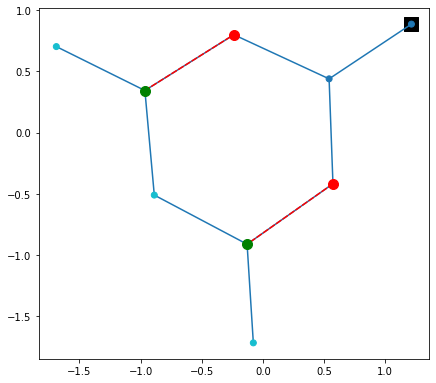

In [12]:
zone = 1
import pandapower.plotting as plot
plot.generic_geodata.create_generic_coordinates(net, overwrite=True)
plot.plotting_toolbox.set_line_geodata_from_bus_geodata(net, overwrite=True)
plot.geo.convert_geodata_to_gis(net)

fig, ax=plt.subplots(figsize=(7,11))

net.line_geodata.plot(ax=ax)
net.line_geodata.loc[list(boundary_branches["line"])].plot(ax=ax, color='red', linestyle="--")
net.bus_geodata.plot(column=net.bus.zone.values, ax=ax,zorder=10)
net.bus_geodata.loc[net.ext_grid.bus.values].plot(ax=ax, color='k', marker="s", markersize=200)

net.bus_geodata.loc[list(buses[zone]["external"])].plot(color='r', ax=ax, zorder=100, markersize=100)
net.bus_geodata.loc[list(buses[zone]["internal"])].plot(color='g', ax=ax, zorder=100, markersize=100)

Now, we can obtain the grid equivalent to reduce the zone 0

In [13]:
b_internal = [net.bus.loc[net.bus.zone==1].index[0]]
net_eq = pp.grid_equivalents.get_equivalent(net, "rei", buses[1]["internal"], b_internal)

hp.pandapower.grid_equivalents.get_equivalent - INFO: rei equivalent calculation started
hp.pandapower.toolbox - INFO: dropped 0 switches
hp.pandapower.toolbox - INFO: dropped 3 load elements
hp.pandapower.toolbox - INFO: dropped 5 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 3 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 1 gen elements
hp.pandapower.toolbox - INFO: dropped 0 switches
hp.pandapower.toolbox - INFO: dropped 1 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 1 gen elements
hp.pandapower.toolbox - INFO: dropped 6 impedance elements
hp.pandapower.toolbox - INFO: dropped 0 switches
hp.pandapower.toolbox - INFO: dropped 5 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 3 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 0 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 3 ext_grid elements
hp.pandapower.grid_equivalents.get_equivalent - INFO: "rei" equivalent finished in 0.

In [14]:
net_eq.bus

,name,vn_kv,type,zone,in_service,max_vm_pu,min_vm_pu
0,1,345.0,b,0,True,1.1,0.9
1,2,345.0,b,1,True,1.1,0.9
5,6,345.0,b,1,True,1.1,0.9
7,8,345.0,b,1,True,1.1,0.9
8,load_integrated-total 2,345.0,b,None,True,1.1,0.9
9,gen_separate-total 2,345.0,b,None,True,NaN,NaN


## Grid equivalents with DC lines

In [15]:
pp.drop_lines(net, [2])
pp.create_dcline(net, 4, 5, 50, 0.5, 0.7, 1.0, 1.0)
pp.runpp(net)

hp.pandapower.toolbox - INFO: dropped 1 lines with 0 line switches


In [16]:
net_eq = pp.grid_equivalents.get_equivalent(net, "rei", [4,8], [0])

hp.pandapower.grid_equivalents.get_equivalent - INFO: replaced dcline [0] by gen elements
hp.pandapower.grid_equivalents.get_equivalent - INFO: rei equivalent calculation started
hp.pandapower.toolbox - INFO: dropped 0 switches
hp.pandapower.toolbox - INFO: dropped 1 load elements
hp.pandapower.toolbox - INFO: dropped 5 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 1 dcline elements
hp.pandapower.toolbox - INFO: dropped 3 gen elements
hp.pandapower.toolbox - INFO: dropped 0 switches
hp.pandapower.toolbox - INFO: dropped 1 ext_grid elements
hp.pandapower.toolbox - INFO: dropped 2 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 1 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 8 impedance elements
hp.pandapower.toolbox - INFO: dropped 0 switches
hp.pandapower.toolbox - INFO: dropped 5 lines with 0 line switches
hp.pandapower.toolbox - INFO: dropped 1 dcline elements
hp.pandapower.toolbox - INFO: dropped 0 lines with 0 line switches
hp.

In [17]:
net_eq.bus

,name,vn_kv,type,zone,in_service,max_vm_pu,min_vm_pu
0,1,345.0,b,0,True,1.1,0.9
3,4,345.0,b,0,True,1.1,0.9
4,5,345.0,b,0,True,1.1,0.9
8,9,345.0,b,0,True,1.1,0.9
9,load_integrated-total 1,345.0,b,None,True,1.1,0.9
10,gen_separate-total 1,345.0,b,None,True,NaN,NaN
11,gen_separate-total 2,345.0,b,None,True,NaN,NaN
12,gen_separate-total 5,345.0,b,None,True,NaN,NaN
